# Building and Training Sequence To Sequence Model
Sources:
 - [Show, Attend and Tell Paper](https://arxiv.org/pdf/1502.03044.pdf)
 - [Andrej Karapthy's Dissertation](https://cs.stanford.edu/people/karpathy/main.pdf) (See section 4.2)
 - [TF Tutorial](https://www.tensorflow.org/tutorials/text/image_captioning)



In [95]:
import pandas as pd 
import numpy as np
import tensorflow as tf
import os
from tqdm import tqdm
import time
import pickle
import csv
#initialization code required to make tensorflow work on my systemabs
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
print(tf.__version__)
from utils import display_samples
from ast import literal_eval
import pathlib

2.4.1


## Load Training Dataset:

We will load our training dataset using a preprocessed dataframe containing:
<ol>
    <li> Captions </li>
    <li> Path to the Image embeddings </li>
    </ol>
As well as a pickled tokenizer created using the captions

In [96]:
#path to file containing dataframe
df_path = r'data/30k_sample/tokenized_sent_added_emb_pos'

In [97]:
#path to pickled tokenizer for training data we will be using
tok_path = r'data/30k_sample/tokenizer_pos.pickle'

In [98]:
data_df = pd.read_csv(df_path, converters={'captions_tokenized_padded': eval})

In [100]:
len(data_df)

21016

In [101]:
with open(tok_path, 'rb') as handle:
    tokenizer = pickle.load(handle)

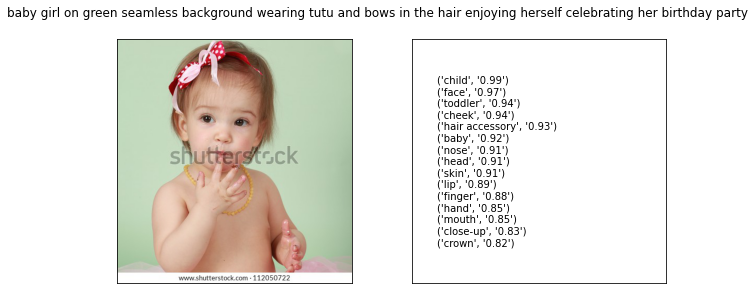

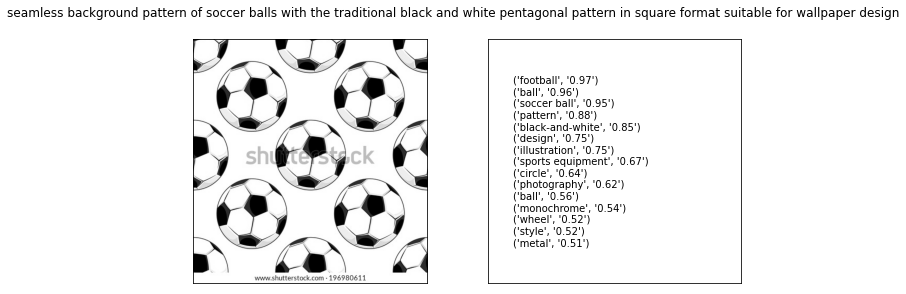

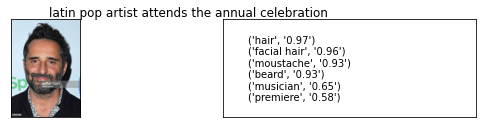

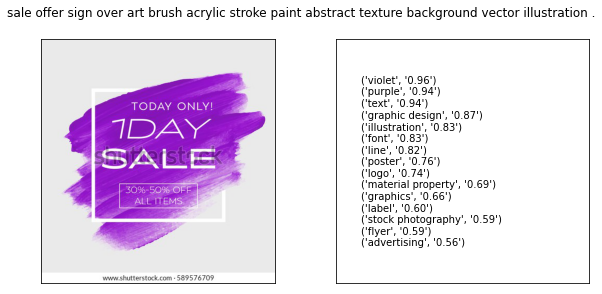

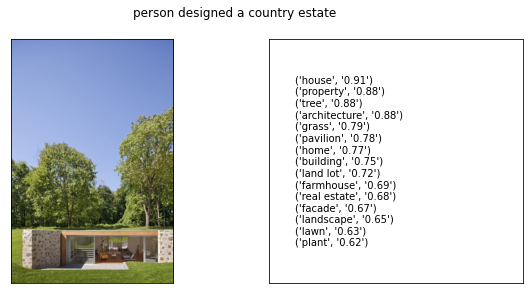

In [102]:
#lets load a quick few samples
display_samples(data_df, seed = 3)

In [103]:
data_df.columns

Index(['Unnamed: 0', 'index', 'global_index', 'caption', 'link', 'objects',
       'mid', 'object_confidences', 'image_path', 'size', 'height', 'width',
       'aspect_ratio', 'num_obj', 'nltk_sent_polarity', 'nltk_sent',
       'nltk_sent_pos_neg', 'nltk_sent_pos_neg_conf', 'hf_sent',
       'hf_sent_class', 'hf_sent_conf', 'captions_processed',
       'captions_tokenized', 'captions_tokenized_padded', 'i_v3_embed_path',
       'i_resnet_v2_embed_path'],
      dtype='object')

## Batch Loading Training Data
In this section, I have attempted to make use of tensorflows Dataset class to create functions to load our data from memory in batches in parrallel to optimize training time.

In [104]:
def map_load_emb_caption(emb_path, caption):
    """
    Purpose is to speed up and batch process loading resnet_v2 embeddings specifically from the 30k sample
    """
    emb = np.load(emb_path)
    return emb, caption

In [105]:
#use our dataframe to create 2 lists: one with image embedding paths and other with respective tokenized and padded captions
image_emb_paths = data_df['i_resnet_v2_embed_path'].tolist()
padded_tokenized_caps = data_df['captions_tokenized_padded'].tolist()

In [106]:
#make sure the lists are the same size and correct
print(len(image_emb_paths), len(padded_tokenized_caps))

21016 21016


In [107]:
type(padded_tokenized_caps[0][0])

int

In [108]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
from tensorflow.data import Dataset, AUTOTUNE

In [109]:

def load_dataset(image_emb_paths, padded_tokenized_captions):
    """
    Takes in list of paths to image embeddings and corresponding list of padded tokenized sequences and loads them into a tensorflow
    Dataset that is batched and uses a buffer size
    """
    dataset = Dataset.from_tensor_slices((image_emb_paths, padded_tokenized_captions))
    dataset = dataset.map(lambda x,y: tf.numpy_function(map_load_emb_caption, [x,y], [tf.float32, tf.int32]),
                         num_parallel_calls=AUTOTUNE)
    dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    return dataset

## Loading and initializing word embeddings matrix

Here, I am using untrainable GloVe embeddings (dim = 300x1)
Other options to experiment with include:
<ol>
    <li> using Word2Vec embeddings
    <li> using higher dimenstional GloVe embeddings
    <li> add a FC layer that is trainable 
    <li> initializing the embedding layer with glove weights but allowing it to be trainable
    <li> suggestion: using bert embeddings: since they tend to be more contextualized

 </ol>
 All this can be done by simply swapping out this word embedding layer in the model for a different one by:
     - loading the appropriate embeddings matrix using the method below with the correct EMBEDDING_DIM

In [110]:
#use the tokenizer we built above to get a word index which we will use to build an embedding matrix for GloVe. Code 
#taken from the same source
def build_embeddings_matrix( my_tokenizer, embeddings_index, EMBEDDING_DIM):
    """
    Given a tokenizer created from our training set and 
    EMBEDDING DIM of a particular pretrained embedding model and
    a dictionary of word->embedding of that model, returns an array 
    where each index of the array corresponds to the embedding of the
    word represented by that index
    """
    word_index = my_tokenizer.word_index
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    for word, i in tqdm(word_index.items()):
        try:
            embedding_vector = embeddings_index.loc[word]    
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
        except KeyError:
            pass
    return embedding_matrix

In [111]:
GLOVE_DIR = r'Word_Embeddings'
words = pd.read_table(os.path.join(GLOVE_DIR, 'glove.6B.300d.txt'), sep=" ", index_col=0, header=None, quoting=csv.QUOTE_NONE)

In [112]:
embedding_matrix = build_embeddings_matrix(tokenizer, words, 300) 

100%|██████████| 10001/10001 [00:53<00:00, 187.83it/s]


## Model

Architecture Parameters:
 - img_emb_dim: number of neurons in FC layer of Encoder that pretrained image embeddings are passed through
 - units: size of RNN hidden layer
 - word_emb_dim: size of word embeddings
 

We will be using a sequence to sequence model that:
<ol>
    <li> <b>ENCODER LAYER </b></li>
    <ol>
        <li> Takes in pretrained CNN embeddings with dims (64x2048 for inception_v3 or 64x1536 for inception_resnet_v2 ): Since this is taken
        from lower convolutional layers, each of the 64  vectors represents a 'part' of the image
        according to the paper <a href = "https://arxiv.org/pdf/1502.03044.pdf"> Show, Attend and Tell </a> </li>
        <li> Passes them through an fully connected layer of output dims: (64ximg_emb_dim) </li>
        <li> Applies Relu activation </li>
    </ol>
    <li> <b>ATTENTION LAYER</b> </li>
    <ol>
        <li> Sits inside the decoder model</li>
        <li> Takes in output of encoder model and RNN's previous hidden state </li>
        <li> Passes a concatenation of these into a Dense Layer with tanh activation with output dims:(64xunits)</li>
        <li> Passes the output of the Dense Layer to a single neuron dense layer to get the attention weights for each of the 64 'parts' of the image. Uses softmax to normalize attention weights</li>
        <li> Finally, each of the 64 vectors in the CNN's output are weighted by their respective attention weight to calculate
            a 'context vector' that is the output of the Attention Layer.</li>
    </ol>
    <li> <b>DECODER LAYER: LSTM</b> </li>
    <ol> 
        <li>Takes in a word and a context vector and outputs the next word in the caption (along with a hidden              state) </li>
        <li>Word is first embedded using GloVe</li>
        <li>Then, image features extracted from CNN along with the hidden state (initialized at 0 for <start> token)
            are passed through attention layer to get context vector
        <li> Context vector and word embedding are concatenated and passed through LSTM to get hidden state and output
        <li> Output is passed through 2 fully connected layer, last one with vocab_size neurons
        <li> Word with highest probability is the next word generated
            </ol>

In [118]:
from tensorflow.keras.layers import Input,Dense,LSTMCell,Embedding, Reshape, Softmax, RepeatVector, Concatenate, Dot
from tensorflow.keras import Model

### Initializing various dimensions and parameters

In [119]:
#loading various dimensions/parameters for the model
emb = np.load(image_emb_paths[0])
emb.shape
num_vecs = emb.shape[0]
img_vec_dims = emb.shape[1]
print(num_vecs, img_vec_dims)

64 1536


In [120]:
vocab_size = len(tokenizer.word_index)
vocab_size

10001

In [121]:
embedding_matrix.shape
word_emb_dim = embedding_matrix.shape[1]
word_emb_dim

300

In [122]:
sizes = {'vocab_size': vocab_size + 1, #size of vocab + 1 , as required buy keras's Embedding Layer
        'word_emb_dim': word_emb_dim, #size of word embedding
         'img_vec_dim': img_vec_dims, #size of each vector in pretrained image embedding 
        'img_num_vec': num_vecs, #number of vectors in pretrained image embedding
         'img_emb_dim': 256, #number of neurons in encoders FC layer
        'lstm_num_units': 512 #number of units in LSTM (LSTM hidden size)
        }

### Constructing/Initializing Models

#### Encoder Layer

In [123]:
## CNN encoder model

def init_encoder(sizes):
    """
    Initializes the CNN encoder model. Takes in the number of vectors outputted by the pretrained image embeddings
    along with the size of these vecors. Also takes in the size we want to embed each vector to.
    
    """
    
    inputs = Input(shape=(sizes['img_num_vec'],sizes['img_vec_dim']))
    outputs = Dense(sizes['img_emb_dim'], activation= 'relu')(inputs)
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

#### Word Embeddings Layer

In [124]:
#converts each word (given as integer index in vocab) to an embedding using pretrained emebddings
def init_word_embedder(sizes,glove_embedding_matrix):
    inputs = Input(shape=(1,))
    
    glove_emb = Embedding(sizes['vocab_size'],
                            sizes['word_emb_dim'],
                            weights=[glove_embedding_matrix],
                            trainable=False, input_length=1)(inputs)
    reshaped = Reshape((sizes['word_emb_dim'],))(glove_emb)
    #outputs = Dense(GLoVe_emb_dim,word_emb_dim)(reshaped)
    model = Model(inputs = inputs, outputs=reshaped)
    return model

#### Attention Layer

In [125]:
def init_attention(sizes):
    enc_output = Input((sizes['img_num_vec'], sizes['img_emb_dim']), name='enc_output')
    prev_hidden =  Input((sizes['lstm_num_units'],),name='prev_hidden')
    
    #repeat hidden so number of dims matches enc_output
    reshaped_hidden = RepeatVector(sizes['img_num_vec'])(prev_hidden)
    
    #concatenate the two inputs
    attention_inp = Concatenate(axis=-1)([enc_output, reshaped_hidden])
    
    #pass through 2 dense layers to calculate attention weights
    attention_dense_1 = Dense(sizes['lstm_num_units']*2, activation = 'tanh')(attention_inp)
    attention_dense_2 = Dense(sizes['lstm_num_units'], activation = 'tanh')(attention_dense_1)
    
    #get attention weights
    attention_weights = Dense(1)(attention_dense_2)
    
    #normalize attention weights
    
    normalized_attention_weights = Softmax(axis=1)(attention_weights)
    
    #calculate context vector by weighting encoder output
    context = Dot(axes = 1)([normalized_attention_weights,enc_output])
    reshaped = Reshape((sizes['img_emb_dim'],))(context)
    
    model = Model(inputs=[enc_output,prev_hidden], outputs=[reshaped, normalized_attention_weights])
    return model



#### Decoder LSTM Layer

In [126]:
def init_decoder(sizes, attention_model):
    
    dec_input = Input((sizes['word_emb_dim'],), name='dec_input')
    hidden_input = Input((sizes['lstm_num_units'],), name='hiden_state')
    attention_context = Input((sizes['img_emb_dim'],), name='attn_context')
    cell_input = Input((sizes['lstm_num_units'],), name = 'cell_state')
    
    LSTM_input = Concatenate(axis=-1)([attention_context, dec_input])
     
    a, state = LSTMCell(sizes['lstm_num_units'])(inputs=LSTM_input, states=[hidden_input,cell_input])
    
    hidden_output = state[0]
    cell_output = state[1]
    
    #pass through fully connected layers
    fc_out_1 = Dense(sizes['lstm_num_units'], activation='relu')(a)
    
    fc_out_2 = Dense(sizes['vocab_size'], activation='softmax')(fc_out_1)
    
    model = Model(inputs=[dec_input,attention_context,hidden_input,cell_input], outputs =[fc_out_2, hidden_output, cell_output])
    
    return model
    
    
    
    
    
    
    
    
    
    
    
    

In [127]:
encoder = init_encoder(sizes)
word_embedder = init_word_embedder(sizes,embedding_matrix)
attention_model = init_attention(sizes)
decoder = init_decoder(sizes,attention_model)

### Save model architechture

In [128]:
#where we will save all our metrics every 5 epochs
output_dir = r'results/30k_i_res_v3_pos'
model_architecture_path = os.path.join(output_dir, 'model_architecture')

In [129]:
if(not os.path.exists(model_architecture_path)):
        pathlib.Path(model_architecture_path).mkdir(parents=True,exist_ok=True )

In [130]:
encoder.save(os.path.join(model_architecture_path, 'encoder'))
decoder.save(os.path.join(model_architecture_path, 'decoder'))
attention_model.save(os.path.join(model_architecture_path, 'attention'))
word_embedder.save(os.path.join(model_architecture_path, 'embedder'))

INFO:tensorflow:Assets written to: results/30k_i_res_v3_pos\model_architecture\encoder\assets
INFO:tensorflow:Assets written to: results/30k_i_res_v3_pos\model_architecture\decoder\assets
INFO:tensorflow:Assets written to: results/30k_i_res_v3_pos\model_architecture\attention\assets
INFO:tensorflow:Assets written to: results/30k_i_res_v3_pos\model_architecture\embedder\assets


## Loss and Optimizer:
We are using the adam optimizer with Sparse Categorical Cross entropy loss

In [131]:
##define optimizer and loss function, taken directly from the tensorflow official tutiorial

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
    #if real caption is equal to zero (has ended), i.e padded then there is no loss
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

## Model Checkpointing 

In [132]:
#where we will save all our metrics every 5 epochs
output_dir = r'results/30k_i_res_v3_pos'
model_path = os.path.join(output_dir, 'model')
metrics_file = r'metrics'



In [133]:
metrics_file_path = os.path.join(output_dir, metrics_file)

In [134]:
metrics_file_path

'results/30k_i_res_v3_pos\\metrics'

In [135]:
if os.path.exists(metrics_file_path):
    metrics_df = pd.read_csv(metrics_file_path)
else:
    #potentially add more metrics depending on how much time it takes?
    if(not os.path.exists(output_dir)):
        pathlib.Path(output_dir).mkdir(parents=True,exist_ok=True )
    metrics_df = pd.DataFrame(columns = ['epoch', 'loss'])

In [142]:
ckpt = tf.train.Checkpoint(encoder_model=encoder,
                           glove_word_embedder = word_embedder,
                           attention_model = attention_model,
                           decoder_model=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, model_path, max_to_keep=50)

In [143]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    start_epoch *=5
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

In [144]:
start_epoch 

20

## Training



In [145]:

@tf.function
def train_step(image_emb, target_seq):
    """
    One step of training given 
    image_emb: pretrained embedding of the image 
    target_seq: tokenized and padded caption sentence
    """
    loss = 0
    batch_size = target_seq.shape[0]
    seq_len = target_seq.shape[1]
    lstm_hidden = tf.zeros((batch_size, sizes['lstm_num_units']))
    lstm_cell = tf.zeros((batch_size, sizes['lstm_num_units']))
    
    #first token is always start token.
    word_token = target_seq[:,0]
    
    with tf.GradientTape() as tape:
        image_enc = encoder(image_emb)
        #skip start token so we dont feed it in twice
        for word_idx in range(1, seq_len):
            target_word = target_seq[:,word_idx]
            img_context, attn_weights = attention_model([image_enc, lstm_hidden])
            dec_input = word_embedder(word_token)
            dec_output, lstm_hidden, lstm_cell = decoder((dec_input, img_context,lstm_hidden,lstm_cell))
            loss += loss_function(target_word, dec_output)
            
            #we are using teacher forcing, so we will be feeding the correct word back into the 
            word_token = target_word
            
        #divide loss by sentence length because we do not want to penalize long sentences
        total_loss = loss/int(seq_len)
        trainable_variables = encoder.trainable_variables +  attention_model.trainable_variables + decoder.trainable_variables
        
        #gradients of trainable variables wrt to loss
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients,trainable_variables))
        
        return loss, total_loss
        

In [146]:
#now, we can finally load the dataset using the pbatched funciton we defined above in section 2
dataset = load_dataset(image_emb_paths,padded_tokenized_caps)
num_steps = len(dataset)
num_steps

329

In [147]:
EPOCHS = 50
loss_plot = []
for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    epoch_end_loss = total_loss / num_steps
    # storing the epoch end loss value to plot later
    loss_plot.append(epoch_end_loss)
    metrics_df = metrics_df.append({'loss':epoch_end_loss, 'epoch':epoch }, ignore_index=True)
    metrics_df.to_csv(metrics_file_path, index=False)
    if epoch % 5 == 0:
        ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 21 Batch 0 Loss 0.3210
Epoch 21 Batch 100 Loss 0.2210
Epoch 21 Batch 200 Loss 0.2413
Epoch 21 Batch 300 Loss 0.2457
Epoch 21 Loss 0.258434
Time taken for 1 epoch 207.17 sec

Epoch 22 Batch 0 Loss 0.2567
Epoch 22 Batch 100 Loss 0.2332
Epoch 22 Batch 200 Loss 0.1841
Epoch 22 Batch 300 Loss 0.2181
Epoch 22 Loss 0.225750
Time taken for 1 epoch 174.63 sec

Epoch 23 Batch 0 Loss 0.2822
Epoch 23 Batch 100 Loss 0.1777
Epoch 23 Batch 200 Loss 0.2016
Epoch 23 Batch 300 Loss 0.1826
Epoch 23 Loss 0.196428
Time taken for 1 epoch 176.10 sec

Epoch 24 Batch 0 Loss 0.2594
Epoch 24 Batch 100 Loss 0.1666
Epoch 24 Batch 200 Loss 0.2050
Epoch 24 Batch 300 Loss 0.1354
Epoch 24 Loss 0.170711
Time taken for 1 epoch 175.72 sec

Epoch 25 Batch 0 Loss 0.2266
Epoch 25 Batch 100 Loss 0.1692
Epoch 25 Batch 200 Loss 0.1858
Epoch 25 Batch 300 Loss 0.1439
Epoch 25 Loss 0.147385
Time taken for 1 epoch 176.66 sec

Epoch 26 Batch 0 Loss 0.1976
Epoch 26 Batch 100 Loss 0.1397
Epoch 26 Batch 200 Loss 0.1302
Epoch 26 